In [1]:
import torch
import copy
from torch.utils.data import TensorDataset
import numpy as np
import matplotlib.pyplot as plt
from models.my_fair import BinaryFair
from models.flow import Flow
from models.classifier import BinaryClassifier
from utils.StatisticalDistance import EmpiricalStatisticalDistance
from sklearn.manifold import TSNE, SpectralEmbedding
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from tqdm.auto import trange
from utils.DataSplitting import *

%load_ext autoreload
%autoreload 2

In [2]:
data_file = torch.load("data/Crime/data.pt")

In [3]:
data = data_file['data']
context = data_file['context']
labels = data_file['labels']

In [4]:
data_train, data_test, context_train, context_test, labels_train, labels_test = train_test_split(data, context, labels, test_size=0.1)
data_train, data_val, context_train, context_val, labels_train, labels_val = train_test_split(data_train, context_train, labels_train, test_size=0.1)

In [16]:
# Parameters
params = {'batch_size': 64,
          'shuffle': True}

# Split data by label
data_0_train = data_train[context_train.flatten()==0]
labels_0_train = labels_train[context_train.flatten()==0]
context_0_train = context_train[context_train.flatten()==0]

data_1_train = data_train[context_train.flatten()==1]
labels_1_train = labels_train[context_train.flatten()==1]
context_1_train = context_train[context_train.flatten()==1]

data_0_test = data_test[context_test.flatten()==0]
labels_0_test = labels_test[context_test.flatten()==0]
context_0_test = context_test[context_test.flatten()==0]

data_1_test = data_test[context_test.flatten()==1]
labels_1_test = labels_test[context_test.flatten()==1]
context_1_test = context_test[context_test.flatten()==1]

data_0_val = data_val[context_val.flatten()==0]
labels_0_val = labels_val[context_val.flatten()==0]
context_0_val = context_val[context_val.flatten()==0]

data_1_val = data_val[context_val.flatten()==1]
labels_1_val = labels_val[context_val.flatten()==1]
context_1_val = context_val[context_val.flatten()==1]

# Generators
label_0_set_train = TensorDataset(data_0_train, labels_0_train, context_0_train)
label_0_generator_train = torch.utils.data.DataLoader(label_0_set_train, **params)

label_1_set_train = TensorDataset(data_1_train, labels_1_train, context_1_train)
label_1_generator_train = torch.utils.data.DataLoader(label_1_set_train, **params)

label_0_set_test = TensorDataset(data_0_test, labels_0_test, context_0_test)
label_0_generator_test = torch.utils.data.DataLoader(label_0_set_test, **params)

label_1_set_test = TensorDataset(data_1_test, labels_1_test, context_1_test)
label_1_generator_test = torch.utils.data.DataLoader(label_1_set_test, **params)

label_0_set_val = TensorDataset(data_0_val, labels_0_val, context_0_val)
label_0_generator_val = torch.utils.data.DataLoader(label_0_set_val, **params)

label_1_set_val = TensorDataset(data_1_val, labels_1_val, context_1_val)
label_1_generator_val = torch.utils.data.DataLoader(label_1_set_val, **params)

In [6]:
#Get label and adversarial accuracy on raw, un-embedded data
data_set_labels_train = TensorDataset(data_train, labels_train.squeeze()) #For label classifier, use data and labels but not context
data_generator_labels_train = torch.utils.data.DataLoader(data_set_labels_train, **params)

data_set_labels_val = TensorDataset(data_val, labels_val.squeeze()) #For label classifier, use data and labels but not context
data_generator_labels_val = torch.utils.data.DataLoader(data_set_labels_val, **params)

data_set_context_train = TensorDataset(data_train, context_train.squeeze()) #For adversairal classifier, use data and context but not labels
data_generator_context_train = torch.utils.data.DataLoader(data_set_context_train, **params)

data_set_context_val = TensorDataset(data_val, context_val.squeeze()) #For adversairal classifier, use data and context but not labels
data_generator_context_val = torch.utils.data.DataLoader(data_set_context_val, **params)

label_classifier = BinaryClassifier(data_dim=data_train.shape[-1])
label_classifier.fit(data_generator_labels_train, data_generator_labels_val)

adversarial_classifier = BinaryClassifier(data_dim=data_train.shape[-1])
adversarial_classifier.fit(data_generator_context_train, data_generator_context_val)

baseline_label_acc = label_classifier.accuracy(data_test, labels_test.squeeze())
baseline_adv_acc = adversarial_classifier.accuracy(data_test, context_test.squeeze())

print("Label accuracy:", baseline_label_acc, "Adversarial accuracy:", baseline_adv_acc)

 14%|█▍        | 6999/50000 [00:07<00:43, 990.32it/s] 


Early stopping reached after 14 epochs


 23%|██▎       | 11499/50000 [00:11<00:39, 978.94it/s] 


Early stopping reached after 23 epochs
Label accuracy: 0.8450000286102295 Adversarial accuracy: 0.949999988079071


In [7]:
probability_flow = Flow(data_dim=data_train.shape[-1], 
                  context_dim=context_train.shape[-1], #for alpha=1 the labels and contexts are the same
                  n_layers = 3,
                  transform_type = 'MaskedPiecewiseQuadraticAutoregressiveTransform', # ? Try Rational quadratic?
                  num_bins = 50,
                  tails='linear',
                  tail_bound=6.0,
        )

In [8]:
tot_loss = probability_flow.fit_prob_flow(
        data_generator_context_train,
        data_generator_context_val,
        lr=1e-4,
        weight_decay=1e-4,
        max_num_epochs=100,
        n_steps_per_epoch=int(1e2),
        patience=10,)

 24%|██▍       | 2399/10000 [00:39<02:04, 60.90it/s]

Early stopping reached after 24 epochs


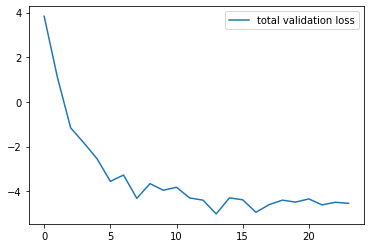

In [10]:
plt.plot(tot_loss, label="total validation loss")

xlims = plt.xlim()
ylims = plt.ylim()
plt.legend()
plt.show()

In [17]:
gamma = 0.5
Fair = BinaryFair(data_dim=data_train.shape[-1], 
                    context_dim=context_train.shape[-1],
                    flow_n_layers = 2,
                    flow_transform_type = 'MaskedPiecewiseQuadraticAutoregressiveTransform', 
                    classifier_hidden_dim = 32,
                    classifier_n_layers = 2,
                    classifier_activation = 'ReLU',
                    num_bins = 50,
                    tails='linear',
                    tail_bound=6.0,
                    gamma=gamma
                    )
# optimizer = torch.optim.AdamW(Fair.parameters(), lr=1e-4, weight_decay=1e-4)
total_losses = []
KL_losses = []
clf_losses = []

In [18]:
# fair_loss = Fair.fit(label_0_generator, label_1_generator, probability_flow, n_steps=4000)
fair_loss = Fair.fit(label_0_generator_train, label_1_generator_train, label_0_generator_val, label_1_generator_val, probability_flow, max_num_epochs=100, n_steps_per_epoch=int(1e2), patience=10,) 

 13%|█▎        | 1299/10000 [06:06<40:53,  3.55it/s] 

Early stopping reached after 13 epochs


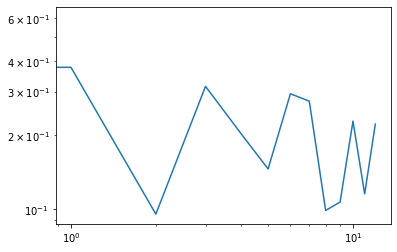

In [20]:
plt.plot(fair_loss, label="fair loss")
plt.xscale('log')
plt.yscale('log')

Text(0.5, 1.0, 'Embedding, gamma = 0.5')

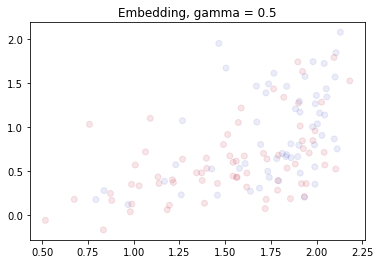

In [99]:
data_0, labels_0, context_0 = next(iter(label_0_generator_test))
data_1, labels_1, context_1 = next(iter(label_1_generator_test))

embedding_0, embedding_1 = Fair._embed(data_0, data_1, context_0=context_0, context_1=context_1)

plt.scatter(*embedding_0.T[0:2].detach(), alpha=0.1, c=labels_0, cmap='coolwarm')
plt.scatter(*embedding_1.T[0:2].detach(), alpha=0.1, c=labels_1, cmap='coolwarm')

plt.title("Embedding, gamma = " + str(gamma))
# plt.savefig("Figures/embedding_gamma_" + str(gamma) + ".png")

For gamma = 1, these two should be on top of one another, but they're not!

In [24]:
with torch.no_grad():
    idx = (data_file["context"] == 0).flatten()
    
    embedding_0, embedding_1 = Fair._embed(
        data_file["data"][idx], data_file["data"][~idx], context_0=data_file["context"][idx], context_1=data_file["context"][~idx]
    )

EmpiricalStatisticalDistance(
    embedding_0, embedding_1, hidden_dim=64, n_layers=5, n_epochs=100
)


100%|██████████| 100/100 [00:04<00:00, 20.98it/s]

Training set accuracy: 0.632
Test set accuracy: 0.631


0.6314553990610329

In [25]:
#Optimal Adversary
#TODO: need to add the context to the data
# idx = (data_file["context"] == 0).flatten()
# data_0 = data_file["data"][idx]
# data_1 = data_file["data"][~idx]
# context_0 = data_file["context"][idx]
# context_1 = data_file["context"][~idx]
data_0, labels_0, context_0 = next(iter(label_0_generator_train))
data_1, labels_1, context_1 = next(iter(label_1_generator_train))

# mu_star_0_avg, mu_star_1_avg, stat_dist, logP_Z0_z0, logP_Z1_z1, logP_Z0_z1, logP_Z1_z0 = Fair.optimal_adversary(data_0, data_1, context_0=context_0, context_1=context_1, probability_flow=probability_flow)
stat_dist, mu_star_0, mu_star_1, = Fair.optimal_adversary(label_0_generator_train, label_1_generator_train, probability_func=probability_flow)


gamma: 0.01 mu_star_0_avg: tensor(0.1875) mu_star_1_ave: tensor(0.8750) stat_dist: tensor(-0.6875)

gamma: 0.9 mu_star_0_avg: tensor(0.2812) mu_star_1_ave: tensor(0.5938) stat_dist: tensor(-0.3125)

In [27]:
gammas = [0.0, 0.02, 0.1, 0.2, 0.9]
Fairs = []

In [29]:
for gamma in gammas:
    Fair = BinaryFair(data_dim=data_train.shape[-1], 
                    context_dim=context_train.shape[-1],
                    flow_n_layers = 2,
                    flow_transform_type = 'MaskedPiecewiseQuadraticAutoregressiveTransform', 
                    classifier_hidden_dim = 32,
                    classifier_n_layers = 2,
                    classifier_activation = 'ReLU',
                    num_bins = 50,
                    tails='linear',
                    tail_bound=6.0,
                    gamma=gamma
                    )
    fair_loss = Fair.fit(label_0_generator_train, label_1_generator_train, label_0_generator_val, label_1_generator_val, probability_flow, max_num_epochs=100, n_steps_per_epoch=int(1e2), patience=10,) 


    Fairs.append(Fair)


 27%|██▋       | 2699/10000 [00:54<02:26, 49.68it/s]


Early stopping reached after 27 epochs


 17%|█▋        | 1699/10000 [07:48<38:11,  3.62it/s]


Early stopping reached after 17 epochs


 19%|█▊        | 1859/10000 [10:55<47:48,  2.84it/s]  


Loss is nan


 32%|███▏      | 3199/10000 [14:45<31:22,  3.61it/s]  


Early stopping reached after 32 epochs


 18%|█▊        | 1799/10000 [19:32<1:29:03,  1.53it/s]  

Early stopping reached after 18 epochs


In [27]:
data_0_test, labels_0_test, context_0_test = next(iter(label_0_generator_test))
data_1_test, labels_1_test, context_1_test = next(iter(label_1_generator_test))
stat_dists=[]
mu0s_arr=[]
mu1s_arr=[]

for fair in Fairs:
    stat_dist, mu0s, mu1s = fair.optimal_adversary(label_0_generator_test, label_1_generator_test,probability_func=probability_flow)
    mu0s_arr.append(mu0s.sum().item()/len(mu0s))
    mu1s_arr.append(mu1s.sum().item()/len(mu1s))
    stat_dists.append(abs(stat_dist.item()))
print(stat_dists)

[1.0, 0.59375, 0.484375, 0.234375, 0.28125]


In [28]:
with torch.no_grad():
    idx = (data_file["context"] == 0).flatten()
    embedding_0, embedding_1 = Fair._embed(
        data_file["data"][idx], data_file["data"][~idx], context_0=data_file["context"][idx], context_1=data_file["context"][~idx])

acc_test = EmpiricalStatisticalDistance(
    embedding_0, embedding_1, hidden_dim=64, n_layers=5, n_epochs=100, report_accuracy=True
)

100%|██████████| 100/100 [00:04<00:00, 21.36it/s]

Training set accuracy: 0.610
Test set accuracy: 0.581


In [ ]:
accs = []
for fair in Fairs:
    with torch.no_grad():
        idx = (data_file["context"] == 0).flatten()
        embedding_0, embedding_1 = fair._embed(
            data_file["data"][idx], data_file["data"][~idx], context_0=data_file["context"][idx], context_1=data_file["context"][~idx])

    acc_test = EmpiricalStatisticalDistance(
        embedding_0, embedding_1, hidden_dim=64, n_layers=5, n_epochs=100, report_accuracy=True
    )
    accs.append(acc_test)

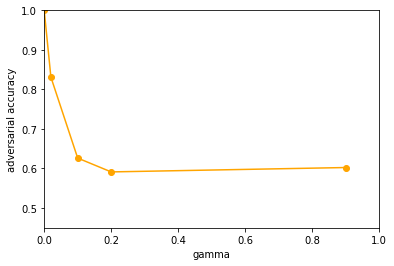

In [33]:
plt.plot(gammas, accs, '-o', color='orange')
plt.xlim(0,1)
plt.ylim(0.45,1)
plt.xlabel('gamma')
plt.ylabel('adversarial accuracy')
plt.show()

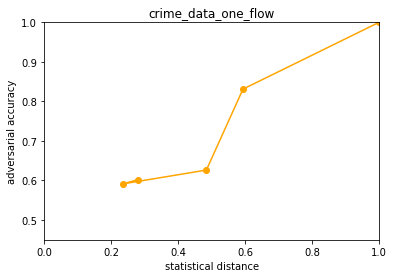

In [36]:
plt.plot(stat_dists, accs, '-o', color='orange')
plt.xlim(0,1)
plt.ylim(0.45,1)
plt.xlabel('statistical distance')
plt.ylabel('adversarial accuracy')
plt.title('crime_data_one_flow')
plt.savefig('crime_data_one_flow.png')
plt.show()


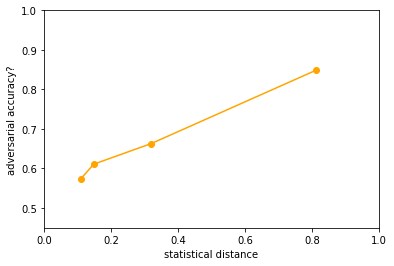

In [ ]:
plt.plot(stat_dists, accs, '-o', color='orange')
plt.xlim(0,1)
plt.ylim(0.45,1)
plt.xlabel('statistical distance')
plt.ylabel('adversarial accuracy?')
plt.show()

add validation set (both to probability flow and FAIR)
85, 10, 5

Check classifier accuracy (separate generation from analysis)
torch.save model
torch.load model
rewrite splitting
save probability flow separately

In [32]:
embedded_label_accs = []
adversary_accs = []
for fair in Fairs:

    # embedding_context_generator, embedding_labels_generator, embedding_data_test, embedding_context_test, embedding_labels_test = get_embedding_data(data_train, labels_train.squeeze(), context_train.squeeze(), data_test, labels_test.squeeze(), context_test.squeeze(), fair)
    embedding_context_generator_train, embedding_labels_generator_train, embedding_context_generator_val, embedding_labels_generator_val, embedding_data_test, embedding_context_test, embedding_labels_test = get_embedding_data(data_train, labels_train.squeeze(), context_train.squeeze(), data_val, labels_val.squeeze(), context_val.squeeze(), data_test, labels_test.squeeze(), context_test.squeeze(), fair)

    adv_classifier = BinaryClassifier(data_dim=data_train.shape[-1])    
    adv_classifier.fit(embedding_context_generator_train,embedding_context_generator_val )
    
    embedded_label_classifier = BinaryClassifier(data_dim=data_train.shape[-1])
    embedded_label_classifier.fit(embedding_labels_generator_train, embedding_labels_generator_val)

    embedded_label_accs.append(embedded_label_classifier.accuracy(embedding_data_test, embedding_labels_test))
    adversary_accs.append(adv_classifier.accuracy(embedding_data_test, embedding_context_test))


 72%|███████▏  | 35999/50000 [00:28<00:11, 1257.90it/s]


Early stopping reached after 72 epochs


 19%|█▉        | 9499/50000 [00:09<00:39, 1027.48it/s]


Early stopping reached after 19 epochs


 18%|█▊        | 8999/50000 [00:07<00:34, 1187.94it/s]


Early stopping reached after 18 epochs


 19%|█▉        | 9499/50000 [00:08<00:34, 1167.51it/s]


Early stopping reached after 19 epochs


 27%|██▋       | 13499/50000 [00:10<00:28, 1274.88it/s]


Early stopping reached after 27 epochs


 15%|█▍        | 7499/50000 [00:05<00:33, 1267.83it/s]


Early stopping reached after 15 epochs


 18%|█▊        | 8999/50000 [00:06<00:31, 1285.96it/s]


Early stopping reached after 18 epochs


 16%|█▌        | 7999/50000 [00:06<00:32, 1294.84it/s]


Early stopping reached after 16 epochs


 26%|██▌       | 12999/50000 [00:10<00:28, 1278.14it/s]


Early stopping reached after 26 epochs


 16%|█▌        | 7999/50000 [00:06<00:32, 1281.19it/s]

Early stopping reached after 16 epochs


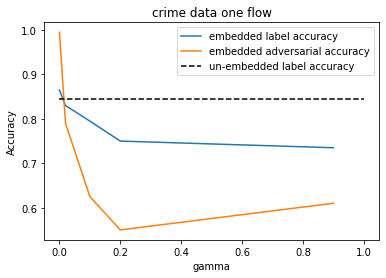

In [33]:
plt.plot(gammas, embedded_label_accs, label='embedded label accuracy')
plt.plot(gammas, adversary_accs, label='embedded adversarial accuracy')
plt.plot(np.linspace(0,1,10),np.ones(10)*baseline_label_acc, 'k--', label='un-embedded label accuracy')


plt.xlabel('gamma')
plt.ylabel('Accuracy')
plt.title('crime data one flow')
plt.legend()
# plt.savefig('single_flow_crime_accuracy.png')
plt.show()